<a href="https://colab.research.google.com/github/Kryptera-K/GLW-Volatility-Trend-Alignment-Strategy-VTA-/blob/main/GLW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "GLW"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("GLW_clean.csv", index=False)
df

/tmp/ipython-input-2666746402.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,26.593466,28.367272,25.938522,28.189892,4650300
2000-01-04,24.014624,26.088612,23.809954,26.047678,6012000
2000-01-05,23.468834,24.151068,22.540998,24.014622,9397200
2000-01-06,22.923048,23.632570,22.800246,23.305098,7239000
2000-01-07,25.515547,25.515547,23.114085,23.141373,11066100
...,...,...,...,...,...
2025-10-07,85.059998,86.230003,83.809998,85.470001,6733000
2025-10-08,87.070000,87.070000,84.760002,85.269997,6088100
2025-10-09,87.190002,87.750000,86.129997,87.150002,4536600


In [ ]:
ATR_LEVEL = 2.0
ATR_PERIOD = 14
ATR_SHIFT = 5
DI_PERIOD = 14
DI_SHIFT_1 = 5
DI_SHIFT_2 = 10
EMA_PERIOD = 20
EMA_SHIFT = 5
STC_CYCLE_LENGTH = 10
STC_FAST_LENGTH = 23
STC_LEVEL = 25
STC_SLOW_LENGTH = 50
STC_SMOOTH = 3

# -------------------------
# Indicator Functions
# -------------------------

def open_below_ema(df, period=EMA_PERIOD):
    df = calculate_ema(df, period)
    return df['Open'] < df['EMA']


def calculate_ema(df, period=EMA_PERIOD):
    """
    Calculate Exponential Moving Average (EMA) of the Close price.
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df


def atr_change_up(df, period=ATR_PERIOD):
    df = calculate_atr(df, period)
    return df['ATR'] > df['ATR'].shift(1)


def calculate_atr(df, period=ATR_PERIOD):
    """
    Calculate ATR (Average True Range)
    df : pandas DataFrame with columns ['High', 'Low', 'Close']
    period : ATR period (default 14)
    """
    df = df.copy()
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(window=period, min_periods=1).mean()
    return df


def stc_above_level(df, level=STC_LEVEL):
    df = calculate_stc(df)
    return df['STC'] > level


def calculate_stc(df, fast=STC_FAST_LENGTH, slow=STC_SLOW_LENGTH, cycle=STC_CYCLE_LENGTH, smooth=STC_SMOOTH):
    # Internal EMA function
    def ema(series, period):
        return series.ewm(span=period, adjust=False).mean()

    # Step 1: MACD line
    fast_ema = ema(df['Close'], fast)
    slow_ema = ema(df['Close'], slow)
    macd_line = fast_ema - slow_ema

    # Step 2: MACD Stochastic
    low_macd = macd_line.rolling(cycle).min()
    high_macd = macd_line.rolling(cycle).max()
    stoch_macd = 100 * (macd_line - low_macd) / (high_macd - low_macd)

    # Step 3: Double smoothed
    stc = ema(ema(stoch_macd, smooth), smooth)
    df['STC'] = stc
    return df


def di_plus_lower_than_minus(df):
    df = calculate_di(df)
    return df['DI+'] < df['DI-']


def calculate_di(df, period=DI_PERIOD):
    """
    Calculate DI+ and DI- indicators.
    """
    df = df.copy()

    # True Range
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # +DM and -DM
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Wilder’s smoothing
    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    # DI+ and DI-
    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])

    return df



# -------------------------
# Entry conditions
# -------------------------

df["EMA_Open_Below"] = open_below_ema(df)
df["ATR_Upward"] = atr_change_up(df)

# -------------------------
# Exit conditions
# -------------------------

df["STC_Above_Level"] = stc_above_level(df)
df["DI+_Lower_Than_DI-"] = di_plus_lower_than_minus(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'EMA_Open_Below',
    'ATR_Upward',
]
exit_conditions = [
    'STC_Above_Level',
    'DI+_Lower_Than_DI-',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-10-13 00:00:00
Period                                6484 days 00:00:00
Start Value                                     100000.0
End Value                                  810500.818402
Total Return [%]                              710.500818
Benchmark Return [%]                          201.916728
Max Gross Exposure [%]                             100.0
Total Fees Paid                             81456.489909
Max Drawdown [%]                               93.434474
Max Drawdown Duration                 3395 days 00:00:00
Total Trades                                         160
Total Closed Trades                                  159
Total Open Trades                                      1
Open Trade PnL                             390028.107588
Win Rate [%]                                   52.830189
Best Trade [%]                                  77.12401
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-10-13 00:00:00
Period                         6484 days 00:00:00
Start Value                              100000.0
End Value                           301916.727641
Total Return [%]                       201.916728
Benchmark Return [%]                   201.916728
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        98.993766
Max Drawdown Duration          6290 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      201916.727641
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2144715003.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


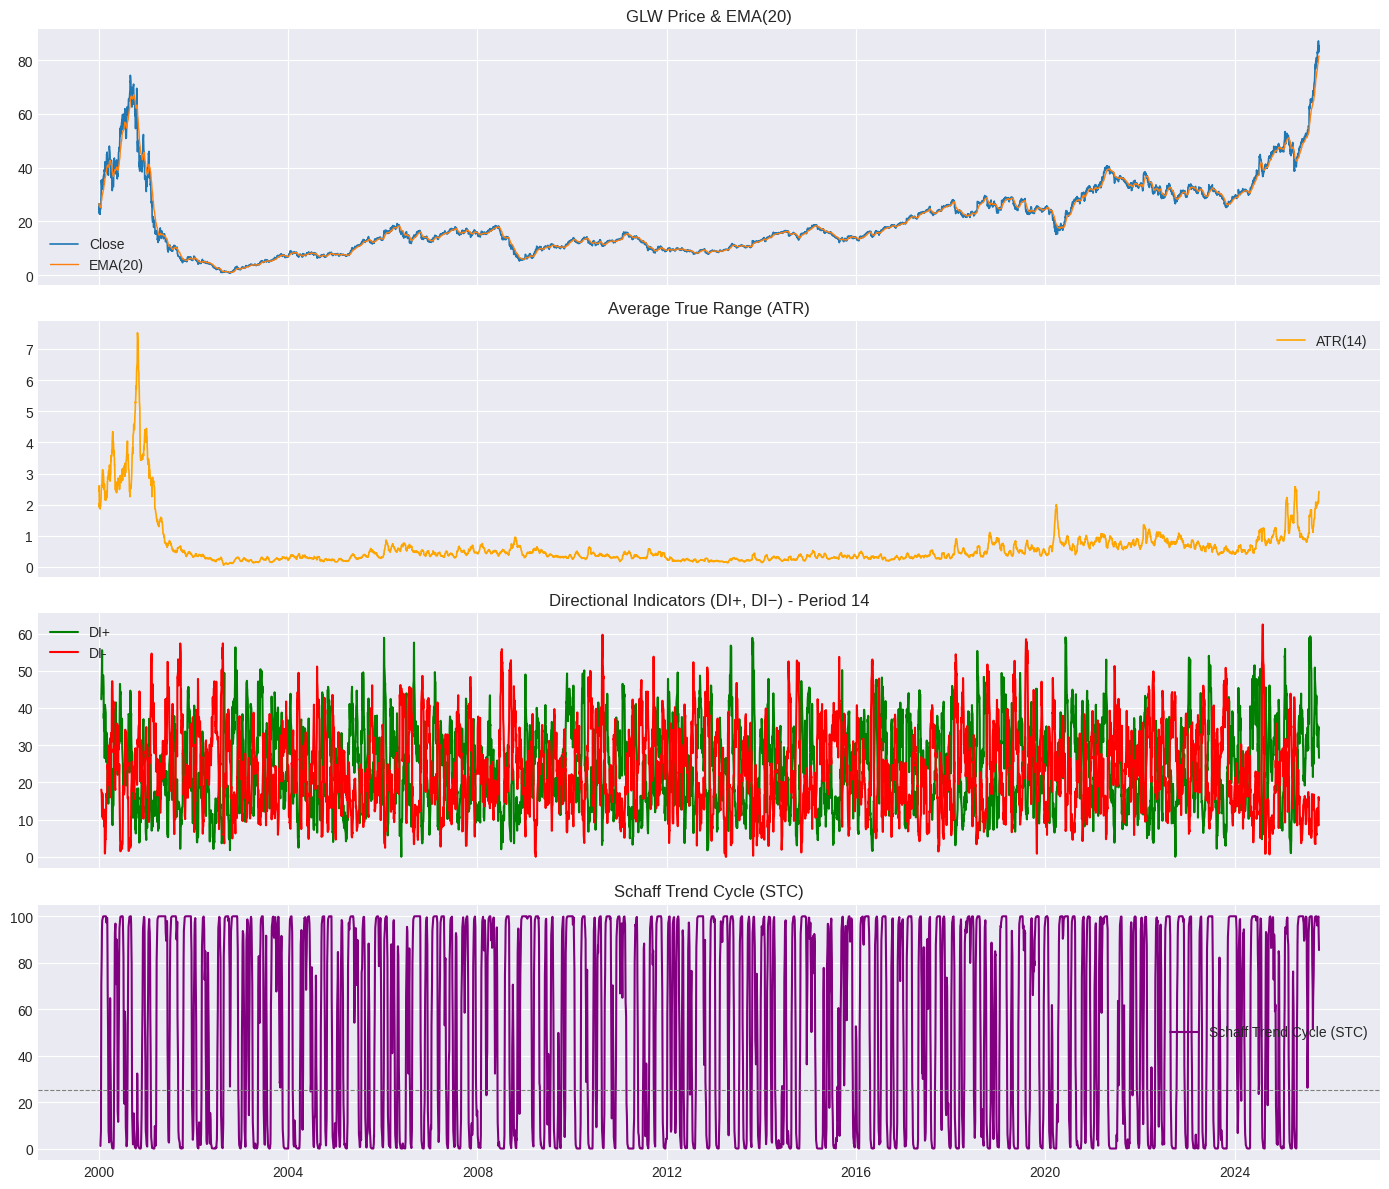

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# =====================================================
# Download Data
# =====================================================
symbol = "GLW"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# =====================================================
# Parameters
# =====================================================
ATR_LEVEL = 2.0
ATR_PERIOD = 14
ATR_SHIFT = 5
DI_PERIOD = 14
DI_SHIFT_1 = 5
DI_SHIFT_2 = 10
EMA_PERIOD = 20
EMA_SHIFT = 5
STC_CYCLE_LENGTH = 10
STC_FAST_LENGTH = 23
STC_LEVEL = 25
STC_SLOW_LENGTH = 50
STC_SMOOTH = 3

# =====================================================
# Indicator Calculation Functions
# =====================================================

def calculate_ema(df, period=EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df

def calculate_atr(df, period=ATR_PERIOD):
    df = df.copy()
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(window=period, min_periods=1).mean()
    return df

def calculate_stc(df, fast=STC_FAST_LENGTH, slow=STC_SLOW_LENGTH, cycle=STC_CYCLE_LENGTH, smooth=STC_SMOOTH):
    def ema(series, period):
        return series.ewm(span=period, adjust=False).mean()

    fast_ema = ema(df['Close'], fast)
    slow_ema = ema(df['Close'], slow)
    macd_line = fast_ema - slow_ema

    low_macd = macd_line.rolling(cycle).min()
    high_macd = macd_line.rolling(cycle).max()
    stoch_macd = 100 * (macd_line - low_macd) / (high_macd - low_macd)
    stc = ema(ema(stoch_macd, smooth), smooth)
    df['STC'] = stc
    return df

def calculate_di(df, period=DI_PERIOD):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()
    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

# =====================================================
# Apply Indicators
# =====================================================
df = calculate_ema(df)
df = calculate_atr(df)
df = calculate_stc(df)
df = calculate_di(df)

# =====================================================
# Plot
# =====================================================
plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# --- Price + EMA ---
axes[0].plot(df.index, df['Close'], label='Close', linewidth=1.2)
axes[0].plot(df.index, df['EMA'], label=f'EMA({EMA_PERIOD})', linewidth=1.0)
axes[0].set_title(f"{symbol} Price & EMA({EMA_PERIOD})")
axes[0].legend()

# --- ATR ---
axes[1].plot(df.index, df['ATR'], color='orange', label=f'ATR({ATR_PERIOD})', linewidth=1.2)
axes[1].set_title('Average True Range (ATR)')
axes[1].legend()

# --- DI+/DI− ---
axes[2].plot(df.index, df['DI+'], color='green', label='DI+')
axes[2].plot(df.index, df['DI-'], color='red', label='DI-')
axes[2].set_title(f"Directional Indicators (DI+, DI−) - Period {DI_PERIOD}")
axes[2].legend()

# --- STC ---
axes[3].plot(df.index, df['STC'], color='purple', label='Schaff Trend Cycle (STC)')
axes[3].axhline(y=STC_LEVEL, color='gray', linestyle='--', linewidth=0.8)
axes[3].set_title(f"Schaff Trend Cycle (STC)")
axes[3].legend()

plt.tight_layout()
plt.show()
